# Chapter 6: Eager and Lazy APIs

In [1]:
import polars as pl
pl.show_versions()

--------Version info---------
Polars:               0.20.7
Index type:           UInt32
Platform:             macOS-12.5-arm64-arm-64bit
Python:               3.11.7 (main, Jan 16 2024, 14:42:22) [Clang 14.0.0 (clang-1400.0.29.202)]

----Optional dependencies----
adbc_driver_manager:  0.8.0
cloudpickle:          3.0.0
connectorx:           0.3.2
deltalake:            0.15.0
fsspec:               2023.12.2
gevent:               23.9.1
hvplot:               0.9.2
matplotlib:           3.8.2
numpy:                1.26.3
openpyxl:             3.1.2
pandas:               2.1.4
pyarrow:              14.0.2
pydantic:             2.5.3
pyiceberg:            0.5.1
pyxlsb:               <not installed>
sqlalchemy:           2.0.25
xlsx2csv:             0.8.2
xlsxwriter:           3.1.9


## Eager API: DataFrame

## Lazy API: LazyFrame

### LazyFrame Scan Level Optimizations

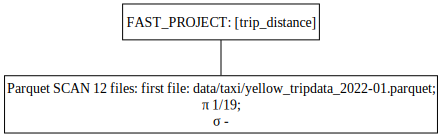

In [5]:
lf = pl.scan_parquet("data/taxi/yellow_tripdata_*.parquet")  # <1>
lf.select(pl.col("trip_distance")).show_graph()  # <2>

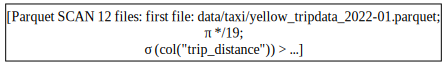

In [6]:
lf.filter(pl.col("trip_distance") > 10).show_graph()

In [7]:
lf.fetch(n_rows=2)

VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
i64,datetime[ns],datetime[ns],f64,f64,f64,str,i64,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64
1,2022-01-01 00:35:40,2022-01-01 00:53:29,2.0,3.8,1.0,"""N""",142,236,1,14.5,3.0,0.5,3.65,0.0,0.3,21.95,2.5,0.0
1,2022-01-01 00:33:43,2022-01-01 00:42:07,1.0,2.1,1.0,"""N""",236,42,1,8.0,0.5,0.5,4.0,0.0,0.3,13.3,0.0,0.0


### Other Optimizations

In [9]:
lazy_df = pl.LazyFrame({
    "foo": [1, 2, 3, 4, 5],
    "bar": [6, 7, 8, 9, 10]
})

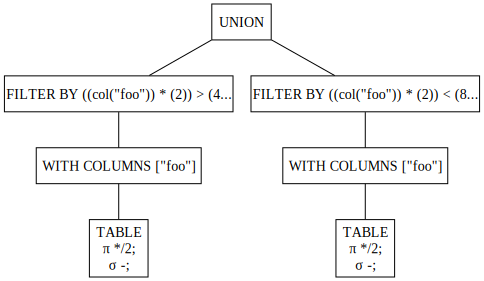

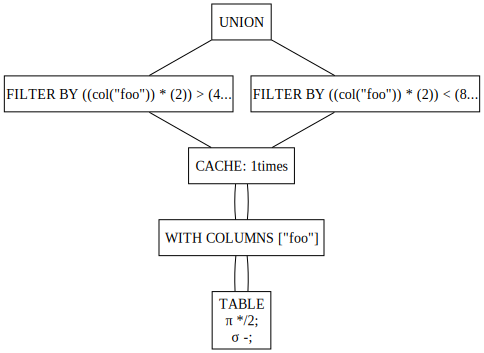

In [10]:
common_subplan = lazy_df.with_columns(pl.col("foo") * 2)

# Utilizing the common subplan in two separate expressions
expr1 = common_subplan.filter(pl.col("foo") * 2 > 4)
expr2 = common_subplan.filter(pl.col("foo") * 2 < 8)

result = pl.concat([expr1, expr2])

result.show_graph(optimized=False)
result.show_graph()

In [11]:
ldf = pl.LazyFrame({
    "name": ["Alice", "Bob", "Charlie"],
    "age": [25, 30, 35]
})

erroneous_query = ldf.with_columns(
    pl.col("age").str.slice(1,3).alias("sliced_age")
)

result_df = erroneous_query.collect()

SchemaError: invalid series dtype: expected `String`, got `i64`

## Performance Differences

In [13]:
lf = pl.LazyFrame({"col1": [1,2,3], "col2": [4,5,6]})
# Some heavy computation
print(lf.collect())
print(lf.with_columns(pl.col("col1") + 1).collect())  # Recalculates the LazyFrame

shape: (3, 2)
┌──────┬──────┐
│ col1 ┆ col2 │
│ ---  ┆ ---  │
│ i64  ┆ i64  │
╞══════╪══════╡
│ 1    ┆ 4    │
│ 2    ┆ 5    │
│ 3    ┆ 6    │
└──────┴──────┘
shape: (3, 2)
┌──────┬──────┐
│ col1 ┆ col2 │
│ ---  ┆ ---  │
│ i64  ┆ i64  │
╞══════╪══════╡
│ 2    ┆ 4    │
│ 3    ┆ 5    │
│ 4    ┆ 6    │
└──────┴──────┘


## Functionality Differences

### Aggregations

### Attributes

### Computation

### Descriptive

### GroupBy

### Exporting

### Manipulation and Selection

### Miscellaneous

## Out-of-Core Computation with Lazy API's Streaming Mode

In [24]:
import numpy as np

x = np.arange(1, 17)
y = np.maximum(12 / x, 1)

plt.figure(figsize=(6, 4))
plt.plot(x, y, 'b-')
plt.xlim([0, 16])
plt.ylim([0, 16])
plt.xlabel('n_threads', {'fontname':'monospace'})
plt.ylabel('thread_factor', {'fontname':'monospace'})
plt.grid(True)
plt.tight_layout()

plt.show()

NameError: name 'plt' is not defined

In [25]:
pl.Config.set_streaming_chunk_size(1000)

polars.config.Config

## Tips and Tricks

### Going from LazyFrame to DataFrame and Vice Versa

### Joining a DataFrame and a LazyFrame

In [29]:
lf = pl.LazyFrame({"id": [1,2,3], "value1": [4,5,6]})
df = pl.DataFrame({"id": [1,2,3], "value2": [7,8,9]})

lf.join(df, on="id")

TypeError: expected `other` join table to be a LazyFrame, not a 'DataFrame'

In [30]:
lf = pl.LazyFrame({"id": [1,2,3], "value1": [4,5,6]})
df = pl.DataFrame({"id": [1,2,3], "value2": [7,8,9]})

lf.join(df.lazy(), on="id")

<LazyFrame [3 cols, {"id": Int64 … "value2": Int64}] at 0x168A7ED10>

### Caching Intermittent Stages

In [32]:
lf = pl.LazyFrame({"col1": [1,2,3], "col2": [4,5,6]})
# Some heavy computation
lf = lf.collect().lazy()
print(lf.collect())
print(lf.with_columns(pl.col("col1") + 1).collect())  # Utilizes the cached LazyFrame

shape: (3, 2)
┌──────┬──────┐
│ col1 ┆ col2 │
│ ---  ┆ ---  │
│ i64  ┆ i64  │
╞══════╪══════╡
│ 1    ┆ 4    │
│ 2    ┆ 5    │
│ 3    ┆ 6    │
└──────┴──────┘
shape: (3, 2)
┌──────┬──────┐
│ col1 ┆ col2 │
│ ---  ┆ ---  │
│ i64  ┆ i64  │
╞══════╪══════╡
│ 2    ┆ 4    │
│ 3    ┆ 5    │
│ 4    ┆ 6    │
└──────┴──────┘


## Conclusion